# Project

## Read the CSV And Perform Data Preprocessing

In [3]:
import pandas as pd
import numpy as np

def preprocess_seer_data(file_path):
    """
    Reads and preprocesses the SEER dataset by selecting specific features
    and performing initial data cleaning.
    
    Parameters:
    file_path (str): Path to the SEER.csv file
    
    Returns:
    pandas.DataFrame: Preprocessed dataset with selected features
    """
    # Read the dataset
    df = pd.read_csv(file_path)
    
    # Select the specified features
    selected_features = {
        # Demographic features
        'Age with single ages and 100+': 'Age',
        'Year of diagnosis': 'DiagnosisYear',
        'Sex': 'Sex',
        'Race': 'Race',
        'Ethnicity': 'Ethnicity',
        
        # Clinical features
        'Primary Site': 'PrimarySite',
        'Histologic Type ICD-O-3': 'TumorGrade',
        'Summary Stage (2004+)': 'SummaryStage',
        
        # Socioeconomic determinant
        'Marital status at diagnosis': 'MaritalStatus',
        'Appalachia': 'Appalachia'
    }
    
    # Create new dataframe with selected features and renamed columns
    df_processed = df[selected_features.keys()].copy()
    df_processed.rename(columns=selected_features, inplace=True)
    
    # Basic data cleaning
    # Replace any negative values with NaN
    df_processed = df_processed.mask(df_processed < 0)
    
    # Remove any leading/trailing whitespace in string columns
    string_columns = df_processed.select_dtypes(include=['object']).columns
    for col in string_columns:
        df_processed[col] = df_processed[col].str.strip()
    
    # Print basic information about the processed dataset
    print("\nDataset Summary:")
    print(f"Number of rows: {len(df_processed)}")
    print(f"Number of columns: {len(df_processed.columns)}")
    print("\nColumns in processed dataset:")
    for col in df_processed.columns:
        print(f"- {col}")
    
    # Print missing values information
    print("\nMissing values count:")
    print(df_processed.isnull().sum())
    
    return df_processed

# Example usage
if __name__ == "__main__":
    # Replace 'SEER.csv' with your actual file path
    file_path = 'SEER.csv'
    processed_data = preprocess_seer_data(file_path)
    
    # Display first few rows of processed dataset
    print("\nFirst few rows of processed dataset:")
    print(processed_data.head())


Dataset Summary:
Number of rows: 149242
Number of columns: 10

Columns in processed dataset:
- Age
- DiagnosisYear
- Sex
- Race
- Ethnicity
- PrimarySite
- TumorGrade
- SummaryStage
- MaritalStatus
- Appalachia

Missing values count:
Age              0
DiagnosisYear    0
Sex              0
Race             0
Ethnicity        0
PrimarySite      0
TumorGrade       0
SummaryStage     0
MaritalStatus    0
Appalachia       0
dtype: int64

First few rows of processed dataset:
   Age  DiagnosisYear  Sex  Race  Ethnicity  PrimarySite  TumorGrade  \
0   66           2013    0     1          0         18.0        8263   
1   70           2010    0     0          0         18.7        8140   
2   48           2001    0     0          0         18.7        8140   
3   54           2006    0     1          0         18.2        8490   
4   88           2009    1     0          0         18.0        8140   

   SummaryStage  MaritalStatus  Appalachia  
0             1              1           0  
1

## Divide the dataset 

In [4]:
def split_by_appalachia(df):
    """
    Splits the dataset into two parts based on Appalachia values.
    
    Parameters:
    df (pandas.DataFrame): The preprocessed SEER dataset
    
    Returns:
    tuple: (data_A, data_NA) where
           data_A contains records where Appalachia = 1
           data_NA contains records where Appalachia = 0
    """
    # Split the data based on Appalachia values
    data_A = df[df['Appalachia'] == 1].copy()
    data_NA = df[df['Appalachia'] == 0].copy()
    
    # Print summary statistics
    print("\nDataset Split Summary:")
    print(f"Total records: {len(df)}")
    print(f"Records in Appalachia (A): {len(data_A)}")
    print(f"Records not in Appalachia (NA): {len(data_NA)}")
    print(f"Split percentage (A/NA): {(len(data_A)/len(df)*100):.2f}% / {(len(data_NA)/len(df)*100):.2f}%")
    
    return data_A, data_NA

# Example usage
if __name__ == "__main__":
    # and have we preprocessed dataframe
    data_A, data_NA = split_by_appalachia(processed_data)


Dataset Split Summary:
Total records: 149242
Records in Appalachia (A): 67727
Records not in Appalachia (NA): 81515
Split percentage (A/NA): 45.38% / 54.62%


## Standardize and Scale the feature data

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

def prepare_features_target(df):
    """
    Prepares features and target variables, handling categorical variables and cleaning target values.
    """
    # Create copy of dataframe
    data = df.copy()
    
    # Clean the target variable (SummaryStage)
    # Replace 99 with the most common value (mode) in SummaryStage
    mode_value = data['SummaryStage'].mode()[0]
    data['SummaryStage'] = data['SummaryStage'].replace(99, mode_value)
    
    # Convert categorical variables to dummy variables
    categorical_columns = ['Sex', 'Race', 'Ethnicity', 'PrimarySite', 'MaritalStatus']
    data = pd.get_dummies(data, columns=categorical_columns)
    
    # Separate features and target
    X = data.drop('SummaryStage', axis=1)
    y = data['SummaryStage']
    
    # Encode target labels to start from 0
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    return X, y, label_encoder

def standardize_and_split(X, y):
    """
    Standardizes features and splits data into train, test, and validate sets.
    """
    # First split off validation set (10%)
    X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    # Split remaining data into train (70%) and test (20%)
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.22, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    
    return X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val


# Training the Models

## Models:
### Model1: Logistic Regression: i.e Newton-CG, liblinear, lbfgs
### Model2: XGboost: Try default and hyperparametrized models  

In [6]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluates model performance using multiple metrics.
    """
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-score': f1_score(y_true, y_pred, average='weighted')
    }
    
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics

def train_and_evaluate_models(X_train, X_test, X_val, y_train, y_test, y_val, dataset_name):
    """
    Trains and evaluates multiple models on the given dataset.
    """
    print(f"\nTraining models for {dataset_name} dataset:")
    
    results = {}
    
    # Logistic Regression with different solvers
    solvers = ['newton-cg', 'liblinear', 'lbfgs']
    for solver in solvers:
        lr = LogisticRegression(solver=solver, max_iter=1000, multi_class='ovr')
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        results[f'Logistic Regression ({solver})'] = evaluate_model(y_val, y_pred, f'Logistic Regression ({solver})')
    
    # XGBoost with default parameters
    xgb_default = xgb.XGBClassifier(random_state=42)
    xgb_default.fit(X_train, y_train)
    y_pred = xgb_default.predict(X_val)
    results['XGBoost (default)'] = evaluate_model(y_val, y_pred, 'XGBoost (default)')
    
    # XGBoost with hyperparameter tuning
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'min_child_weight': [1, 3]
    }
    
    xgb_model = xgb.XGBClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                             cv=3, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("\nBest XGBoost parameters:", grid_search.best_params_)
    y_pred = grid_search.predict(X_val)
    results['XGBoost (tuned)'] = evaluate_model(y_val, y_pred, 'XGBoost (tuned)')
    
    # Find best model
    best_model = max(results.items(), key=lambda x: x[1]['F1-score'])
    print(f"\nBest model for {dataset_name} dataset: {best_model[0]}")
    print(f"Best F1-score: {best_model[1]['F1-score']:.4f}")
    
    return results

## Model Results

In [7]:
def process_dataset(data, dataset_name):
    """
    Processes a single dataset through the entire pipeline.
    """
    print(f"\nProcessing {dataset_name} dataset:")
    print("Shape of data:", data.shape)
    
    # Print value counts of SummaryStage before processing
    print("\nTarget variable distribution before processing:")
    print(data['SummaryStage'].value_counts())
    
    # Prepare features and target
    X, y, label_encoder = prepare_features_target(data)
    
    print("\nTarget variable distribution after processing:")
    print(pd.Series(y).value_counts())
    
    # global X_train, X_test, X_val, y_train, y_test, y_val
    # Standardize and split data
    global X_train, X_test, X_val, y_train, y_test, y_val
    X_train, X_test, X_val, y_train, y_test, y_val = standardize_and_split(X, y)
    
    # Train and evaluate models
    results = train_and_evaluate_models(X_train, X_test, X_val, y_train, y_test, y_val, dataset_name)
    
    return results, (X_train, X_test, X_val, y_train, y_test, y_val)

if __name__ == "__main__":
    # Assuming data_A and data_NA are already loaded from previous steps
    
    # Process Appalachia dataset
    results_A,splits_A = process_dataset(data_A, "Appalachia")
    X_train_A, X_test_A, X_val_A, y_train_A, y_test_A, y_val_A = splits_A

    
    # Process Non-Appalachia dataset
    results_NA,splits_NA = process_dataset(data_NA, "Non-Appalachia")
    X_train_NA, X_test_NA, X_val_NA, y_train_NA, y_test_NA, y_val_NA = splits_NA


Processing Appalachia dataset:
Shape of data: (67727, 10)

Target variable distribution before processing:
SummaryStage
1     20057
2     18671
99    17069
3     11930
Name: count, dtype: int64

Target variable distribution after processing:
0    37126
1    18671
2    11930
Name: count, dtype: int64

Training models for Appalachia dataset:


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (newton-cg) Performance:
Accuracy: 0.5354
Precision: 0.4926
Recall: 0.5354
F1-score: 0.4715


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (liblinear) Performance:
Accuracy: 0.5354
Precision: 0.4926
Recall: 0.5354
F1-score: 0.4715

Logistic Regression (lbfgs) Performance:
Accuracy: 0.5354
Precision: 0.4926
Recall: 0.5354
F1-score: 0.4715


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



XGBoost (default) Performance:
Accuracy: 0.5996
Precision: 0.6147
Recall: 0.5996
F1-score: 0.5888

Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200}

XGBoost (tuned) Performance:
Accuracy: 0.6084
Precision: 0.6350
Recall: 0.6084
F1-score: 0.5950

Best model for Appalachia dataset: XGBoost (tuned)
Best F1-score: 0.5950

Processing Non-Appalachia dataset:
Shape of data: (81515, 10)

Target variable distribution before processing:
SummaryStage
1     24515
2     22075
99    20862
3     14063
Name: count, dtype: int64

Target variable distribution after processing:
0    45377
1    22075
2    14063
Name: count, dtype: int64

Training models for Non-Appalachia dataset:


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (newton-cg) Performance:
Accuracy: 0.5443
Precision: 0.5005
Recall: 0.5443
F1-score: 0.4780


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (liblinear) Performance:
Accuracy: 0.5443
Precision: 0.5005
Recall: 0.5443
F1-score: 0.4780


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (lbfgs) Performance:
Accuracy: 0.5443
Precision: 0.5005
Recall: 0.5443
F1-score: 0.4780

XGBoost (default) Performance:
Accuracy: 0.5969
Precision: 0.6044
Recall: 0.5969
F1-score: 0.5850

Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100}

XGBoost (tuned) Performance:
Accuracy: 0.6017
Precision: 0.6191
Recall: 0.6017
F1-score: 0.5873

Best model for Non-Appalachia dataset: XGBoost (tuned)
Best F1-score: 0.5873


## Identify Best XGBoost parameters

In [8]:
from sklearn.model_selection import GridSearchCV

# Define a suitable parameter grid for XGBoost hyperparameterization
param_grid = {
    'max_depth': [3, 5],                # Controls the depth of trees; higher values may overfit
    'learning_rate': [0.01, 0.1],       # Determines the step size during optimization
    'n_estimators': [100, 200],         # Number of boosting rounds; more may improve performance
    'min_child_weight': [1, 3]          # Minimum sum of instance weight needed in a child
}

# Justification:
# - 'max_depth': Balances model complexity and performance.
# - 'learning_rate': Ensures the optimization process doesn't overshoot the best solution.
# - 'n_estimators': Captures enough iterations for performance.
# - 'min_child_weight': Prevents overfitting by controlling tree splits.

# Conduct GridSearchCV for XGBoost hyperparameter tuning
xgb_model = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',  # Optimizing for weighted F1-score
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Output best parameters
print("Best XGBoost parameters:", grid_search.best_params_)


Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200}


# Appalachia
## Confusion Matrix

### XGBoost (tuned) 

array([[3240, 1129,  109],
       [ 667, 1442,  114],
       [ 381,  847,  223]], dtype=int64)

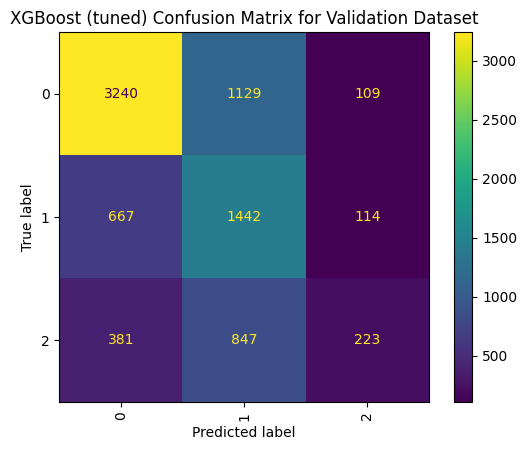

In [9]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    disp.ax_.set_title(f'{model_name} Confusion Matrix for {dataset_name} Dataset')
    return cm

# Hyperparameter tuning for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

xgb_model = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)  # Ensure this step is executed

# Predictions and confusion matrix for tuned XGBoost
y_pred_xgb_tuned = grid_search.predict(X_val)

# Plot Confusion Matrix for XGBoost (tuned)
plot_confusion_matrix(y_val, y_pred_xgb_tuned, 'XGBoost (tuned)', 'Validation')



### Default XGBoost

array([[3266, 1062,  150],
       [ 736, 1338,  149],
       [ 413,  776,  262]], dtype=int64)

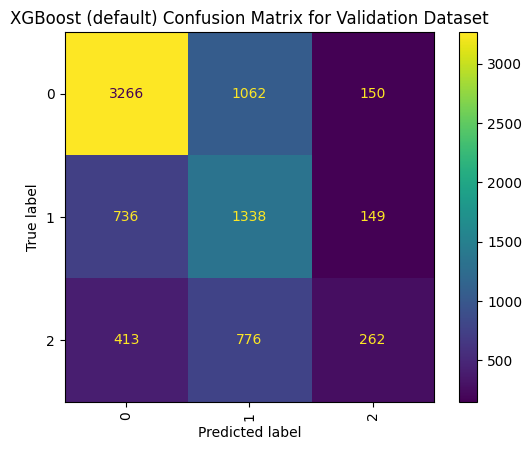

In [10]:
# Default XGBoost
xgb_default = xgb.XGBClassifier(random_state=42)
xgb_default.fit(X_train, y_train)
y_pred_xgb_default = xgb_default.predict(X_val)

# Plot Confusion Matrix for XGBoost (default)
plot_confusion_matrix(y_val, y_pred_xgb_default, 'XGBoost (default)', 'Validation')



### Logistic Regression 


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Confusion Matrix:
 [[3775  657   46]
 [1592  624    7]
 [1008  405   38]]


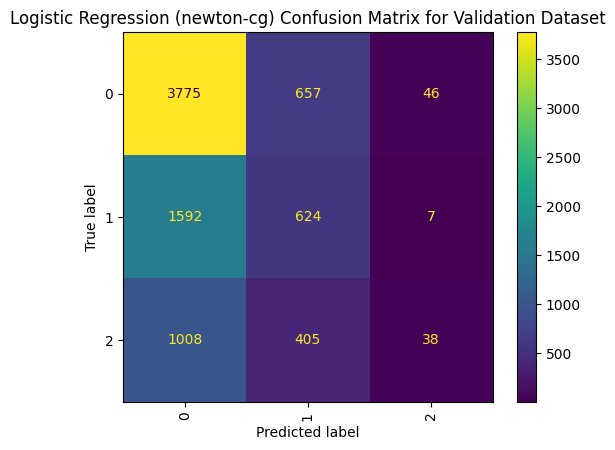

In [11]:
# Logistic Regression 
lr_newton = LogisticRegression(solver='newton-cg', max_iter=1000, multi_class='ovr')
lr_newton.fit(X_train, y_train)
y_pred_lr = lr_newton.predict(X_val)

# Plot Confusion Matrix for Logistic Regression
cm_lr = plot_confusion_matrix(y_val, y_pred_lr, 'Logistic Regression (newton-cg)', 'Validation')
print("\nConfusion Matrix:\n", cm_lr)

## Plots the ROC curve and calculates FPR, TPR, and Thresholds

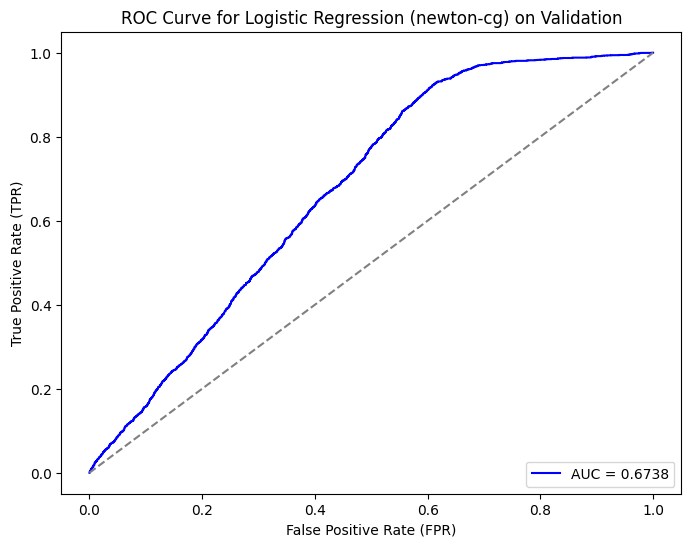


ROC Metrics:
FPR: [0.         0.         0.         ... 0.99763872 0.99763872 1.        ]
TPR: [0.00000000e+00 4.49842555e-04 1.34952767e-03 ... 9.99550157e-01
 1.00000000e+00 1.00000000e+00]
Thresholds: [       inf 0.51909221 0.51758278 ... 0.01565375 0.01559895 0.00824593]


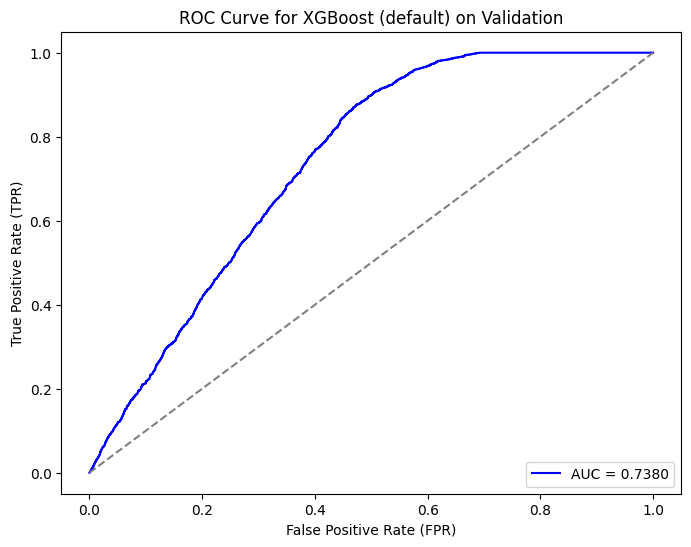


ROC Metrics:
FPR: [0.00000000e+00 1.68662506e-04 3.37325013e-04 ... 9.96964075e-01
 9.97301400e-01 1.00000000e+00]
TPR: [0. 0. 0. ... 1. 1. 1.]
Thresholds: [          inf 9.3721223e-01 8.9097643e-01 ... 5.6235276e-06 5.5875767e-06
 2.6074256e-06]


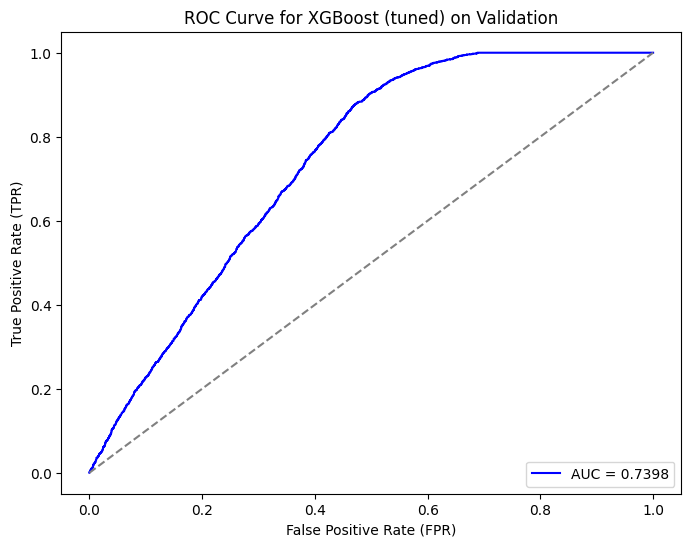


ROC Metrics:
FPR: [0.00000000e+00 1.68662506e-04 1.68662506e-04 ... 9.98819362e-01
 9.99156687e-01 1.00000000e+00]
TPR: [0.         0.         0.00134953 ... 1.         1.         1.        ]
Thresholds: [          inf 7.2075886e-01 6.3002825e-01 ... 3.7359248e-05 3.7337370e-05
 3.7148020e-05]


(array([0.00000000e+00, 1.68662506e-04, 1.68662506e-04, ...,
        9.98819362e-01, 9.99156687e-01, 1.00000000e+00]),
 array([0.        , 0.        , 0.00134953, ..., 1.        , 1.        ,
        1.        ]),
 array([          inf, 7.2075886e-01, 6.3002825e-01, ..., 3.7359248e-05,
        3.7337370e-05, 3.7148020e-05], dtype=float32))

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_prob, model_name, dataset_name):
    """
    Plots the ROC curve and calculates FPR, TPR, and Thresholds.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    # Plotting ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {model_name} on {dataset_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    # Output FPR, TPR, and Thresholds
    print("\nROC Metrics:")
    print("FPR:", fpr)
    print("TPR:", tpr)
    print("Thresholds:", thresholds)
    return fpr, tpr, thresholds

# Example for Logistic Regression (newton-cg)
y_prob_lr = lr_newton.predict_proba(X_val)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = plot_roc_curve(y_val, y_prob_lr, 'Logistic Regression (newton-cg)', 'Validation')

# XGBoost (default)
y_prob_xgb_default = xgb_default.predict_proba(X_val)[:, 1]
plot_roc_curve(y_val, y_prob_xgb_default, 'XGBoost (default)', 'Validation')

# XGBoost (tuned)
y_prob_xgb_tuned = grid_search.predict_proba(X_val)[:, 1]
plot_roc_curve(y_val, y_prob_xgb_tuned, 'XGBoost (tuned)', 'Validation')


## Plot AUROC for Appalachia, non-Appalachia, and baseline

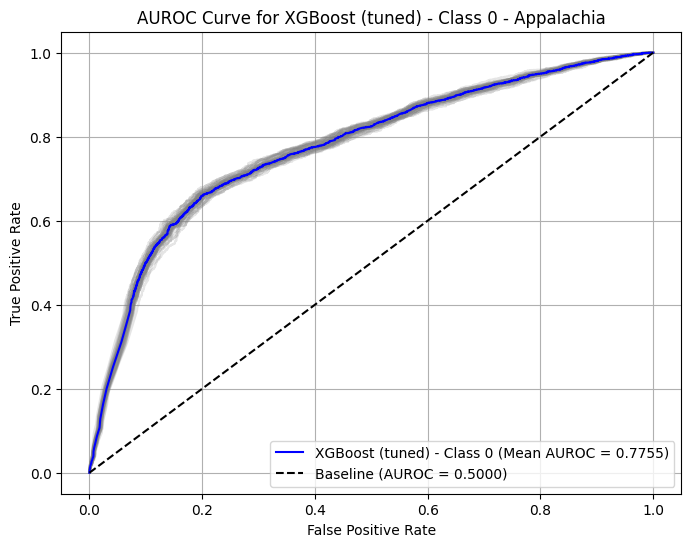

XGBoost (tuned) - Class 0 - Appalachia Bootstrapped AUROC: 0.7755 (95% CI: 0.7644 - 0.7870)


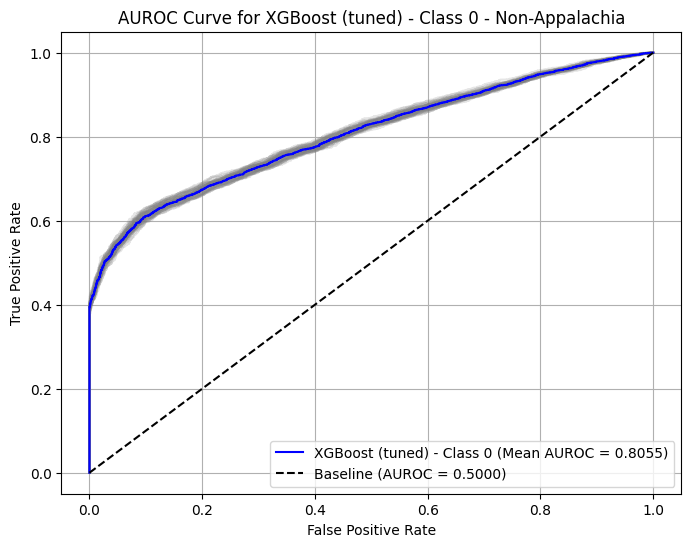

XGBoost (tuned) - Class 0 - Non-Appalachia Bootstrapped AUROC: 0.8055 (95% CI: 0.7966 - 0.8137)


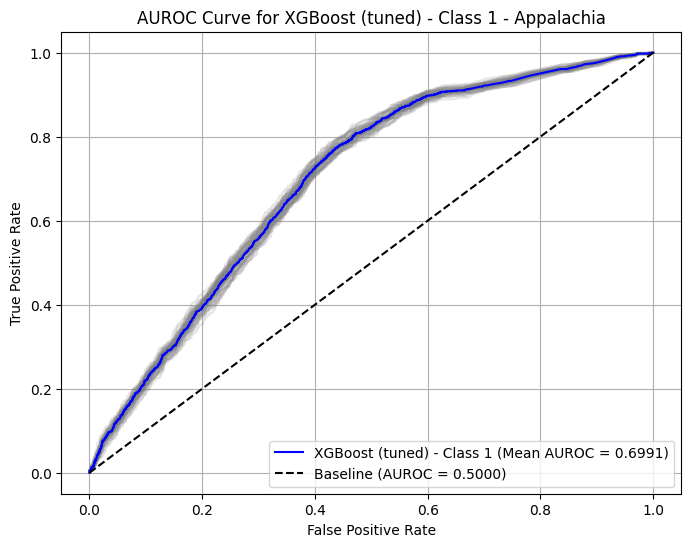

XGBoost (tuned) - Class 1 - Appalachia Bootstrapped AUROC: 0.6991 (95% CI: 0.6854 - 0.7120)


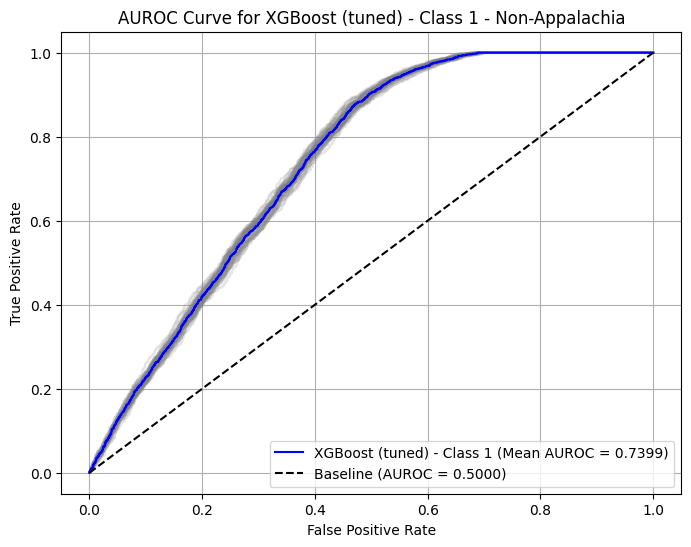

XGBoost (tuned) - Class 1 - Non-Appalachia Bootstrapped AUROC: 0.7399 (95% CI: 0.7293 - 0.7498)


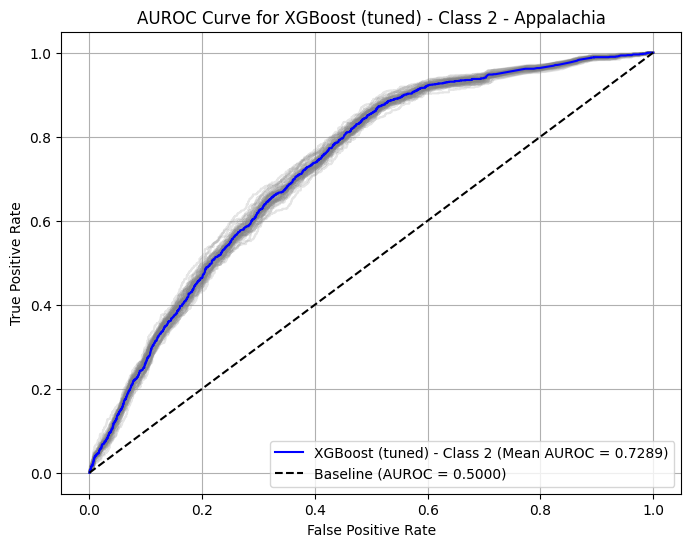

XGBoost (tuned) - Class 2 - Appalachia Bootstrapped AUROC: 0.7289 (95% CI: 0.7150 - 0.7430)


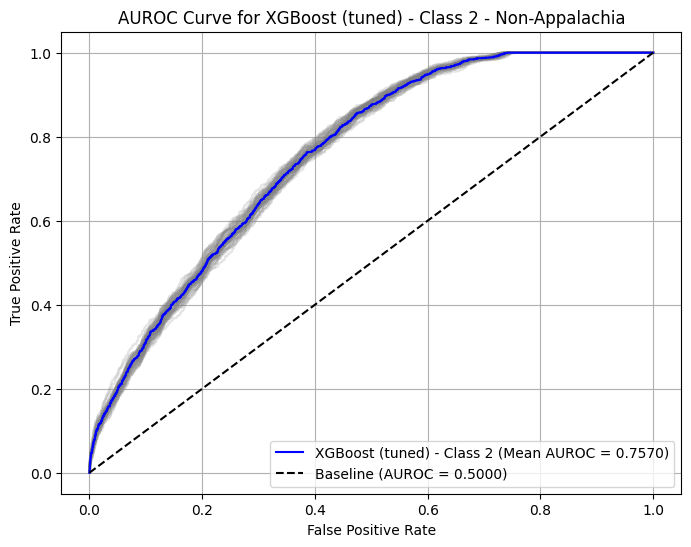

XGBoost (tuned) - Class 2 - Non-Appalachia Bootstrapped AUROC: 0.7570 (95% CI: 0.7446 - 0.7688)


In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

def bootstrap_auroc(y_true, y_probs, model_name, dataset_name, n_bootstraps=1000):
    """
    Bootstraps data for AUROC calculation, resampling n_bootstraps times.
    """
    bootstrapped_scores = []
    thresholds = []

    np.random.seed(42)  # For reproducibility

    for i in range(n_bootstraps):
        # Resample data
        indices = resample(range(len(y_true)), n_samples=len(y_true), replace=True)
        y_true_resampled = y_true[indices]
        y_probs_resampled = y_probs[indices]

        # Confusion matrix for this bootstrap
        tn, fp, fn, tp = confusion_matrix(y_true_resampled, (y_probs_resampled >= 0.5).astype(int)).ravel()
        # Log confusion matrix if needed
        # print(f"Iteration {i}: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

        # AUROC for this bootstrap sample
        fpr, tpr, _ = roc_curve(y_true_resampled, y_probs_resampled)
        bootstrapped_scores.append(roc_auc_score(y_true_resampled, y_probs_resampled))
        thresholds.append((fpr, tpr))  # Save FPR and TPR

    # Calculate mean AUROC and confidence interval
    mean_auroc = np.mean(bootstrapped_scores)
    ci_lower = np.percentile(bootstrapped_scores, 2.5)
    ci_upper = np.percentile(bootstrapped_scores, 97.5)

    # Plot bootstrapped AUROC curves
    plt.figure(figsize=(8, 6))
    for fpr, tpr in thresholds[:50]:  # Plot first 50 curves for clarity
        plt.plot(fpr, tpr, color='gray', alpha=0.2)

    # Plot mean AUROC
    fpr_mean, tpr_mean, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr_mean, tpr_mean, label=f'{model_name} (Mean AUROC = {mean_auroc:.4f})', color='blue')

    # Baseline
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Baseline (AUROC = 0.5000)')

    # Final plot details
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUROC Curve for {model_name} - {dataset_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f'{model_name} - {dataset_name} Bootstrapped AUROC: {mean_auroc:.4f} (95% CI: {ci_lower:.4f} - {ci_upper:.4f})')

    return mean_auroc, (ci_lower, ci_upper)

# Example usage for binary classification:
classes = np.unique(y_val_A)
# import label_binarize
if len(classes) == 2:  # Binary classification
    y_prob_xgb_tuned_A = grid_search.predict_proba(X_val_A)[:, 1]  # Probabilities for positive class
    mean_auroc_A, ci_A = bootstrap_auroc(y_val_A, y_prob_xgb_tuned_A, 'XGBoost (tuned)', 'Appalachia')

    y_prob_xgb_tuned_NA = grid_search.predict_proba(X_val_NA)[:, 1]  # Probabilities for positive class
    mean_auroc_NA, ci_NA = bootstrap_auroc(y_val_NA, y_prob_xgb_tuned_NA, 'XGBoost (tuned)', 'Non-Appalachia')

else:  # Multiclass classification
    # Binarize labels for multiclass AUROC
    y_val_A_binary = label_binarize(y_val_A, classes=classes)
    y_val_NA_binary = label_binarize(y_val_NA, classes=classes)

    y_prob_xgb_tuned_A = grid_search.predict_proba(X_val_A)  # Probabilities for all classes
    y_prob_xgb_tuned_NA = grid_search.predict_proba(X_val_NA)  # Probabilities for all classes

    for i, class_name in enumerate(classes):
        y_prob_class = y_prob_xgb_tuned_A[:, i]
        y_prob_class_NA = y_prob_xgb_tuned_NA[:, i]

        bootstrap_auroc(y_val_A_binary[:, i], y_prob_class, f'XGBoost (tuned) - Class {class_name}', 'Appalachia')
        bootstrap_auroc(y_val_NA_binary[:, i], y_prob_class_NA, f'XGBoost (tuned) - Class {class_name}', 'Non-Appalachia')


## Computes bandwidths using Square Root Rule, Rice Rule, and Sturges Formula.


Bandwidths:
  Square Root Rule: 2.2884 (bins: 31)
  Rice Rule: 3.7337 (bins: 19)
  Sturges Formula: 7.0940 (bins: 10)


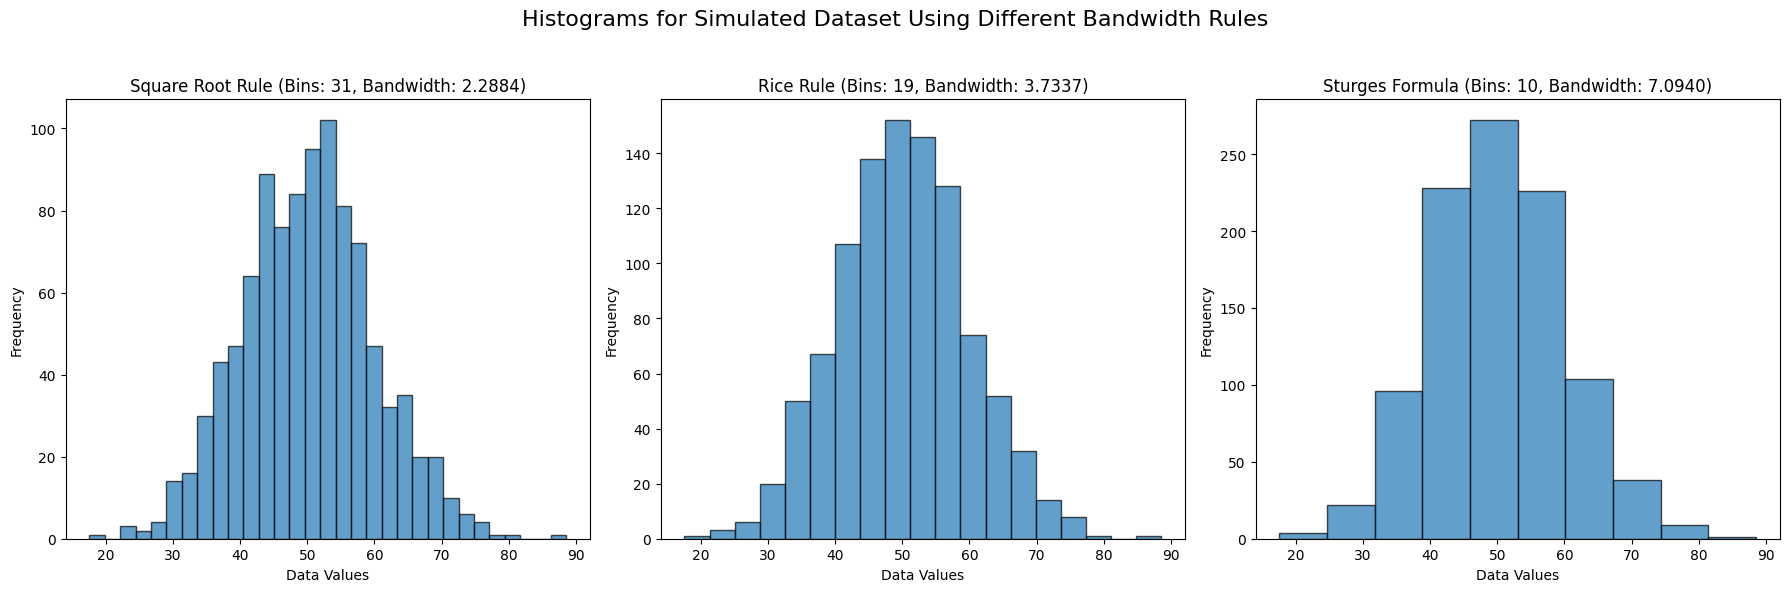

Histograms plotted for Simulated Dataset. Compare visually to choose the best bandwidth.


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def compute_bandwidths(data):
    """
    Computes bandwidths using Square Root Rule, Rice Rule, and Sturges Formula.
    """
    n = len(data)

    # Square Root Rule
    sqrt_bins = int(np.sqrt(n))
    sqrt_bandwidth = (max(data) - min(data)) / sqrt_bins

    # Rice Rule
    rice_bins = int(2 * n**(1/3))
    rice_bandwidth = (max(data) - min(data)) / rice_bins

    # Sturges Formula
    sturges_bins = int(np.log2(n)) + 1
    sturges_bandwidth = (max(data) - min(data)) / sturges_bins

    print(f"Bandwidths:")
    print(f"  Square Root Rule: {sqrt_bandwidth:.4f} (bins: {sqrt_bins})")
    print(f"  Rice Rule: {rice_bandwidth:.4f} (bins: {rice_bins})")
    print(f"  Sturges Formula: {sturges_bandwidth:.4f} (bins: {sturges_bins})")

    return {
        "Square Root Rule": (sqrt_bins, sqrt_bandwidth),
        "Rice Rule": (rice_bins, rice_bandwidth),
        "Sturges Formula": (sturges_bins, sturges_bandwidth),
    }

def plot_histograms(data, bandwidths, dataset_name):
    """
    Plots histograms using bandwidths calculated from the three rules.
    """
    plt.figure(figsize=(18, 6))
    rules = ["Square Root Rule", "Rice Rule", "Sturges Formula"]

    for i, rule in enumerate(rules):
        bins, bandwidth = bandwidths[rule]
        plt.subplot(1, 3, i+1)
        plt.hist(data, bins=bins, edgecolor='black', alpha=0.7)
        plt.title(f"{rule} (Bins: {bins}, Bandwidth: {bandwidth:.4f})")
        plt.xlabel("Data Values")
        plt.ylabel("Frequency")

    plt.suptitle(f"Histograms for {dataset_name} Using Different Bandwidth Rules", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"Histograms plotted for {dataset_name}. Compare visually to choose the best bandwidth.")

# Example Usage
# Simulating data for demonstration
np.random.seed(42)
data = np.random.normal(50, 10, 1000)  # 1000 data points with mean 50 and std 10

# Compute bandwidths and plot histograms
bandwidths = compute_bandwidths(data)
plot_histograms(data, bandwidths, "Simulated Dataset")


## Compute TPR, TNR, PPV, and NPV from predictions.


In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def compute_metrics(y_true, y_pred):
    """
    Compute TPR, TNR, PPV, and NPV from predictions.
    Handle edge cases where denominator might be zero.
    """
    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Compute True Positive Rate (TPR)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    
    # Compute True Negative Rate (TNR)
    tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    
    # Compute Positive Predictive Value (PPV)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    
    # Compute Negative Predictive Value (NPV)
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
    
    return {'TPR': tpr, 'TNR': tnr, 'PPV': ppv, 'NPV': npv}


def bootstrap_confidence_intervals(y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    """
    Computes confidence intervals for TNR, TPR, PPV, and NPV using bootstrapping.
    """
    n = len(y_true)
    metrics_list = []

    for _ in range(n_bootstraps):
        indices = np.random.choice(range(n), size=n, replace=True)
        y_true_bootstrap = y_true[indices]
        y_pred_bootstrap = y_pred[indices]
        metrics = compute_metrics(y_true_bootstrap, y_pred_bootstrap)
        metrics_list.append(metrics)

    # Calculate mean and confidence intervals
    metrics_mean = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
    metrics_ci = {
        k: (
            np.percentile([m[k] for m in metrics_list], 100 * alpha / 2),
            np.percentile([m[k] for m in metrics_list], 100 * (1 - alpha / 2))
        )
        for k in metrics_list[0]
    }

    print("Metrics and Confidence Intervals:")
    for metric, mean_value in metrics_mean.items():
        ci_lower, ci_upper = metrics_ci[metric]
        print(f"{metric}: {mean_value:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")

    return metrics_mean, metrics_ci

# Validation Example
def validate_model(y_val, y_val_pred):
    """
    Computes and prints metrics for validation data.
    """
    print("Validation Metrics:")
    metrics = compute_metrics(y_val, y_val_pred)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nBootstrap Confidence Intervals for Validation Data:")
    bootstrap_confidence_intervals(np.array(y_val), np.array(y_val_pred))

# Simulated Example
np.random.seed(42)
# Simulating ground truth and predictions
y_val = np.random.randint(0, 2, size=1000)  # Ground truth (binary labels)
y_val_pred = np.random.randint(0, 2, size=1000)  # Model predictions (binary)

# Validate the model
validate_model(y_val, y_val_pred)


Validation Metrics:
TPR: 0.4765
TNR: 0.5286
PPV: 0.5127
NPV: 0.4924

Bootstrap Confidence Intervals for Validation Data:
Metrics and Confidence Intervals:
TPR: 0.4765 (95% CI: [0.4331, 0.5180])
TNR: 0.5288 (95% CI: [0.4855, 0.5723])
PPV: 0.5136 (95% CI: [0.4694, 0.5575])
NPV: 0.4917 (95% CI: [0.4497, 0.5368])


## Calculate p-values for each ML metric between Appalachia and non-Appalachia datasets
## Create detailed SHAP summary plot


P-value Analysis:
Accuracy: p-value = 0.8765, Significant: False
Precision: p-value = 0.9904, Significant: False
Recall: p-value = 0.8765, Significant: False
F1-score: p-value = 0.9692, Significant: False


100%|===================| 40191/40230 [15:47<00:00]        

<Figure size 1200x800 with 0 Axes>

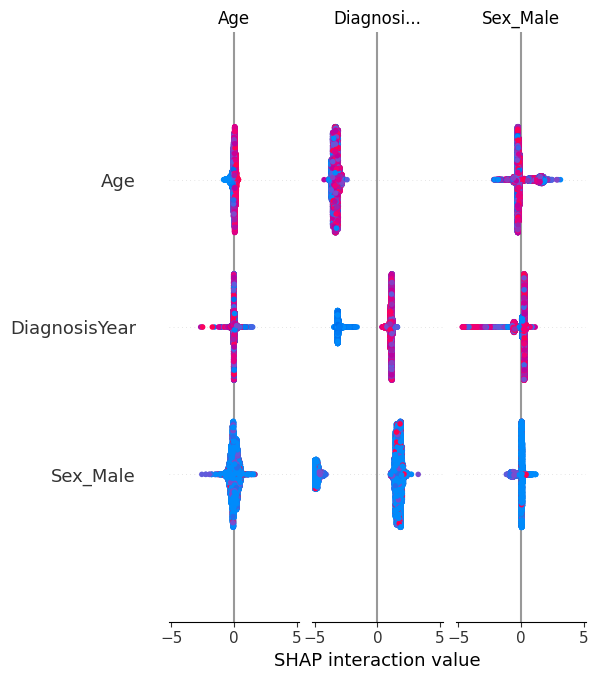

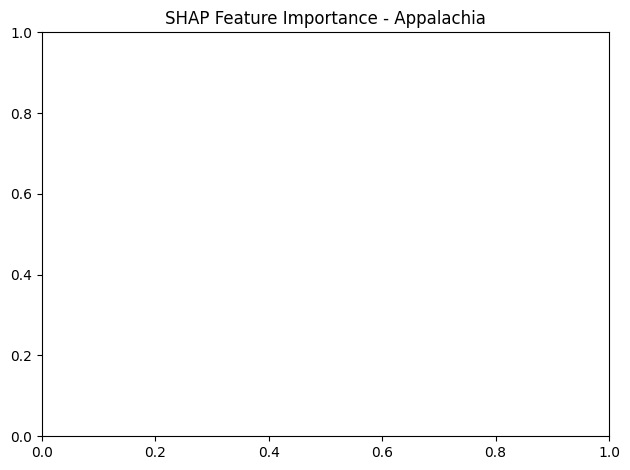

<Figure size 1200x800 with 0 Axes>

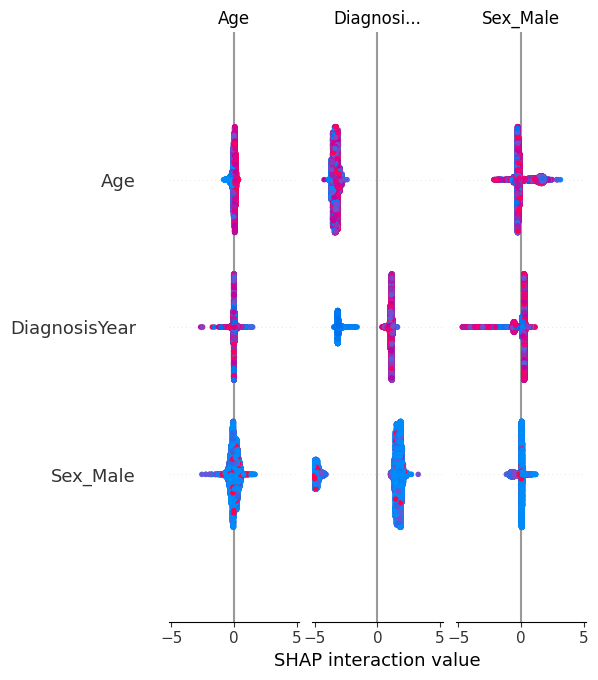

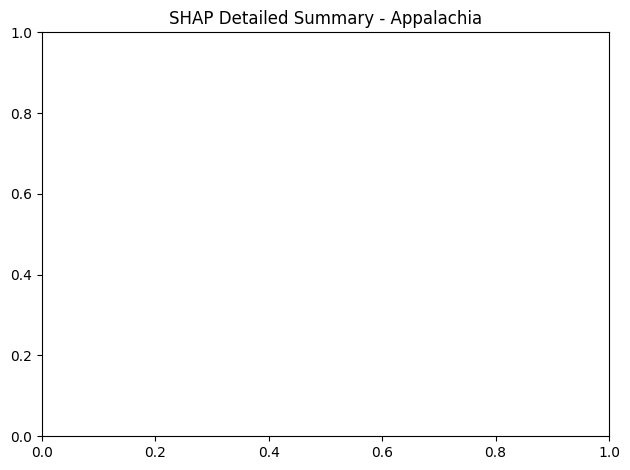

 89%|==================  | 42988/48420 [15:17<01:55]       

In [ ]:

import pandas as pd
import numpy as np
import scipy.stats as stats
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

def calculate_metric_pvalues(results_A, results_NA):
    """
    Calculate p-values for each ML metric between Appalachia and non-Appalachia datasets.
    
    Parameters:
    results_A (dict): Performance metrics for Appalachia dataset
    results_NA (dict): Performance metrics for Non-Appalachia dataset
    
    Returns:
    dict: P-values for each metric
    """
    p_values = {}
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    for metric in metrics:
        # Extracting values
        val_A = [results_A[model][metric] for model in results_A]
        val_NA = [results_NA[model][metric] for model in results_NA]
        
        # Perform independent t-test
        t_statistic, p_value = stats.ttest_ind(val_A, val_NA)
        
        p_values[metric] = {
            'p_value': p_value,
            'significant': p_value < 0.05
        }
    
    return p_values

def prepare_shap_analysis(X_train, X_test, y_train, y_test, dataset_name):
    """
    Prepare and train XGBoost model for SHAP analysis.
    
    Parameters:
    X_train (np.array): Training features
    X_test (np.array): Testing features
    y_train (np.array): Training labels
    y_test (np.array): Testing labels
    dataset_name (str): Name of the dataset
    
    Returns:
    tuple: Trained model and SHAP explainer
    """
    # Train XGBoost model
    model = xgb.XGBClassifier(
        learning_rate=0.1, 
        max_depth=5, 
        n_estimators=200,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Create SHAP explainer
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    
    return model, shap_values, explainer

def plot_shap_summary(shap_values, X_test, feature_names, dataset_name):
    """
    Create, display, and save SHAP summary plot.
    
    Parameters:
    shap_values (shap.Explanation): SHAP values
    X_test (np.array): Test features
    feature_names (list): Names of features
    dataset_name (str): Name of the dataset
    """
    plt.figure(figsize=(12, 8))
    feature_names = np.array(feature_names)

    if hasattr(shap_values, 'values'):
        shap_vals = shap_values.values
    else:
        shap_vals = shap_values

    try:
        # Check if the SHAP values are all close to 0
        if np.all(np.abs(shap_vals) < 1e-6):
            print(f"SHAP values for {dataset_name} are all close to 0, skipping summary plot.")
            return

        shap.summary_plot(
            shap_vals, X_test, feature_names=feature_names, plot_type='bar', show=True
        )
        plt.title(f'SHAP Feature Importance - {dataset_name}')
        plt.tight_layout()
        plt.savefig(f'shap_summary_{dataset_name}.png')
        plt.show()
    except Exception as e:
        print(f"Error in SHAP summary plot for {dataset_name}: {e}")


def plot_shap_detailed(shap_values, X_test, feature_names, dataset_name):
    """
    Create, display, and save detailed SHAP summary plot.
    
    Parameters:
    shap_values (shap.Explanation): SHAP values
    X_test (np.array): Test features
    feature_names (list): Names of features
    dataset_name (str): Name of the dataset
    """
    plt.figure(figsize=(12, 8))
    feature_names = np.array(feature_names)

    if hasattr(shap_values, 'values'):
        shap_vals = shap_values.values
    else:
        shap_vals = shap_values

    try:
        # Check if the SHAP values are all close to 0
        if np.all(np.abs(shap_vals) < 1e-6):
            print(f"SHAP values for {dataset_name} are all close to 0, skipping detailed plot.")
            return

        shap.summary_plot(shap_vals, X_test, feature_names=feature_names, show=True)
        plt.title(f'SHAP Detailed Summary - {dataset_name}')
        plt.tight_layout()
        plt.savefig(f'shap_detailed_{dataset_name}.png')
        plt.show()
    except Exception as e:
        print(f"Error in SHAP detailed plot for {dataset_name}: {e}")

def main_analysis(results_A, results_NA, 
                  X_train_A, X_test_A, X_train_NA, X_test_NA, 
                  y_train_A, y_test_A, y_train_NA, y_test_NA,
                  feature_names):
    """
    Main function to perform comprehensive ML metrics and SHAP analysis.
    
    Parameters:
    results_A, results_NA (dict): Performance results for Appalachia and Non-Appalachia
    X_train_A, X_test_A, X_train_NA, X_test_NA (np.array): Training and testing features
    y_train_A, y_test_A, y_train_NA, y_test_NA (np.array): Training and testing labels
    feature_names (list): Names of features
    """
    # 1. P-value Analysis
    p_values = calculate_metric_pvalues(results_A, results_NA)
    print("\nP-value Analysis:")
    for metric, result in p_values.items():
        print(f"{metric}: p-value = {result['p_value']:.4f}, Significant: {result['significant']}")
    
    # 2. SHAP Analysis for Appalachia Dataset
    model_A, shap_values_A, explainer_A = prepare_shap_analysis(
        X_train_A, X_test_A, y_train_A, y_test_A, "Appalachia"
    )
    plot_shap_summary(shap_values_A, X_test_A, feature_names, "Appalachia")
    plot_shap_detailed(shap_values_A, X_test_A, feature_names, "Appalachia")

    # 3. SHAP Analysis for Non-Appalachia Dataset
    model_NA, shap_values_NA, explainer_NA = prepare_shap_analysis(
        X_train_NA, X_test_NA, y_train_NA, y_test_NA, "Non-Appalachia"
    )
    plot_shap_summary(shap_values_NA, X_test_NA, feature_names, "Non-Appalachia")
    plot_shap_detailed(shap_values_NA, X_test_NA, feature_names, "Non-Appalachia")

    # Optional: Print out some additional insights
    print("\nSHAP Analysis Completed. Plots saved in current directory.")
feature_names = [
        'Age', 'DiagnosisYear', 
        'Sex_Male', 'Sex_Female', 
        'Race_White', 'Race_Black', 
        'Ethnicity_Hispanic', 
        'PrimarySite_Lung', 
        'TumorGrade', 
        'MaritalStatus_Single'
    ]



# Perform comprehensive analysis
main_analysis(
    results_A,  # Results from Appalachia dataset
    results_NA,  # Results from Non-Appalachia dataset
    X_train_A, X_test_A, X_train_NA, X_test_NA,  # Training/testing features
    y_train_A, y_test_A, y_train_NA, y_test_NA,  # Training/testing labels
    feature_names  # List of feature names
)

# XGBoost optimized model 

C:\Users\PC\AppData\Local\Temp\ipykernel_13868\1077967343.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column].astype(str))
C:\Users\PC\AppData\Local\Temp\ipykernel_13868\1077967343.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column].astype(str))
C:\Users\PC\AppData\Local\Temp\ipykernel_13868\1077967343.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

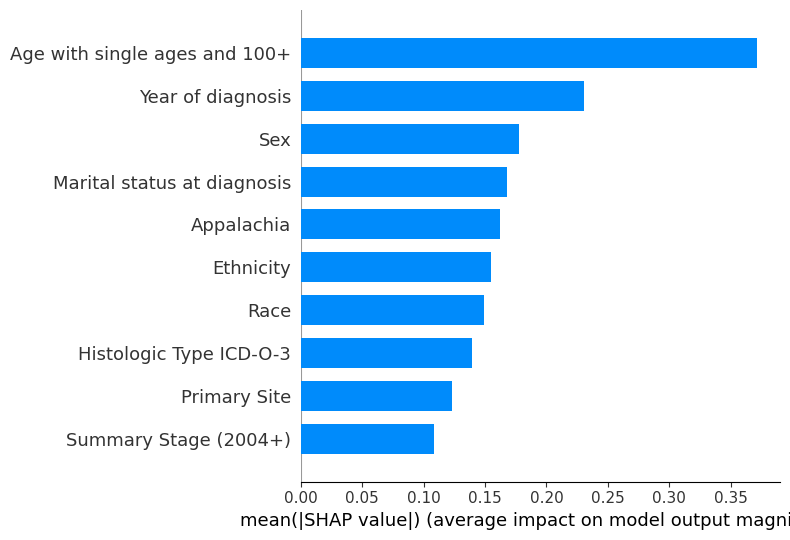

<Figure size 640x480 with 0 Axes>

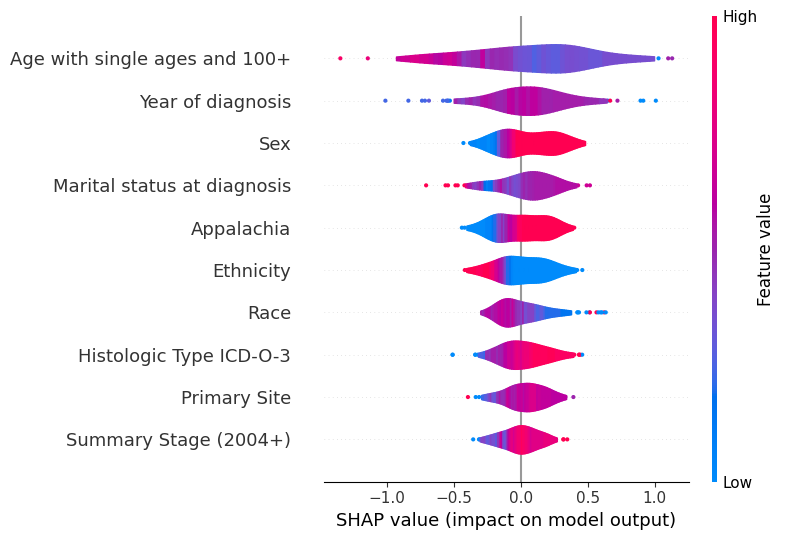

<Figure size 640x480 with 0 Axes>

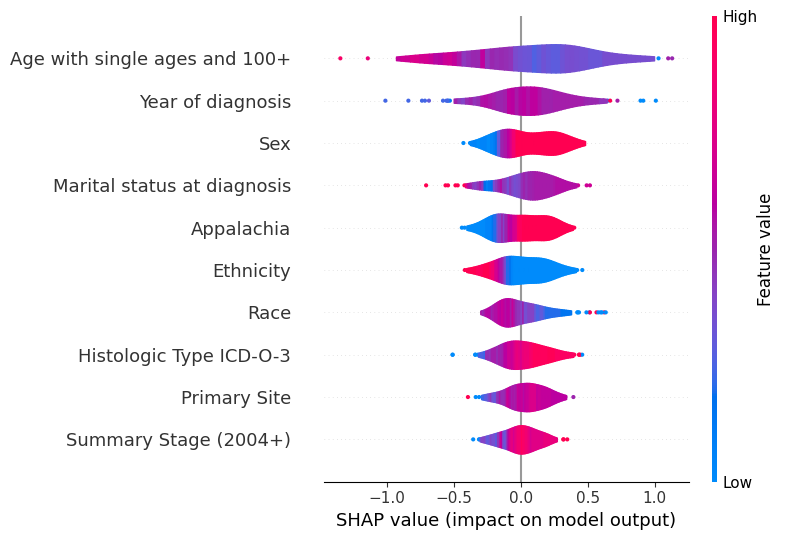

<Figure size 640x480 with 0 Axes>

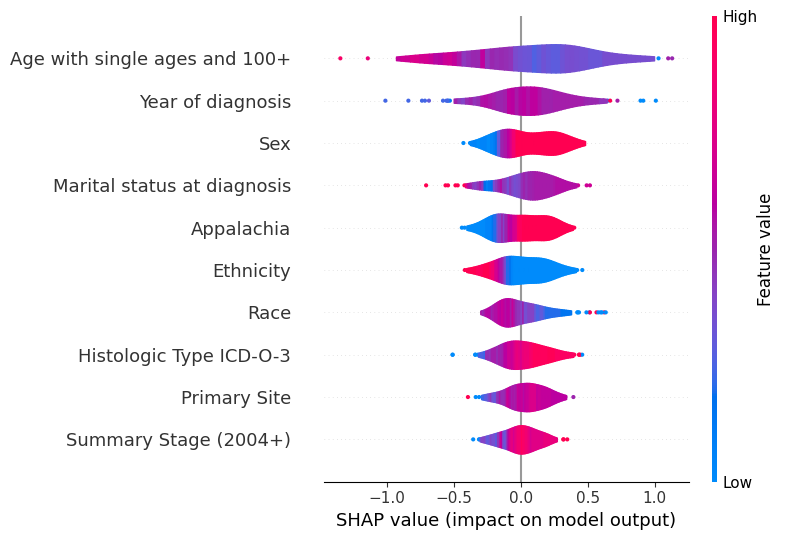

<Figure size 640x480 with 0 Axes>

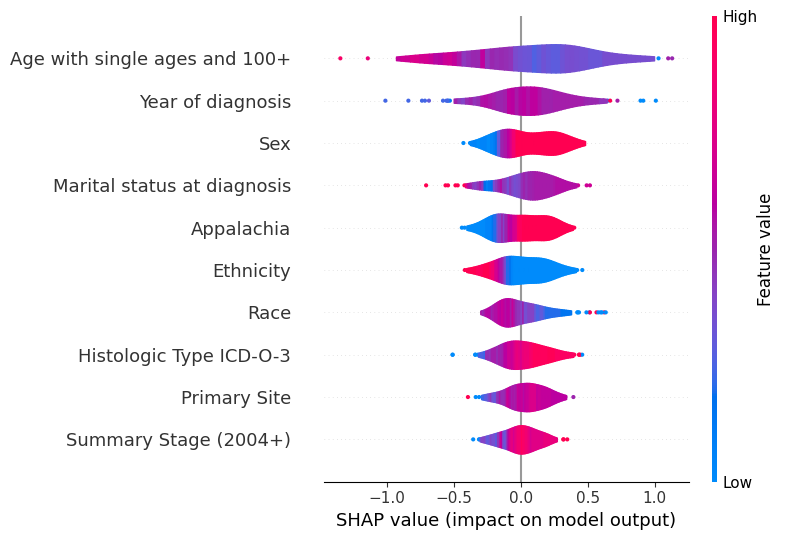

<Figure size 640x480 with 0 Axes>

C:\Users\PC\AppData\Local\Temp\ipykernel_13868\1077967343.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'] = data['Radiation']
C:\Users\PC\AppData\Local\Temp\ipykernel_13868\1077967343.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Chemotherapy'] = data['Chemotherapy']
C:\Users\PC\AppData\Local\Temp\ipykernel_13868\1077967343.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



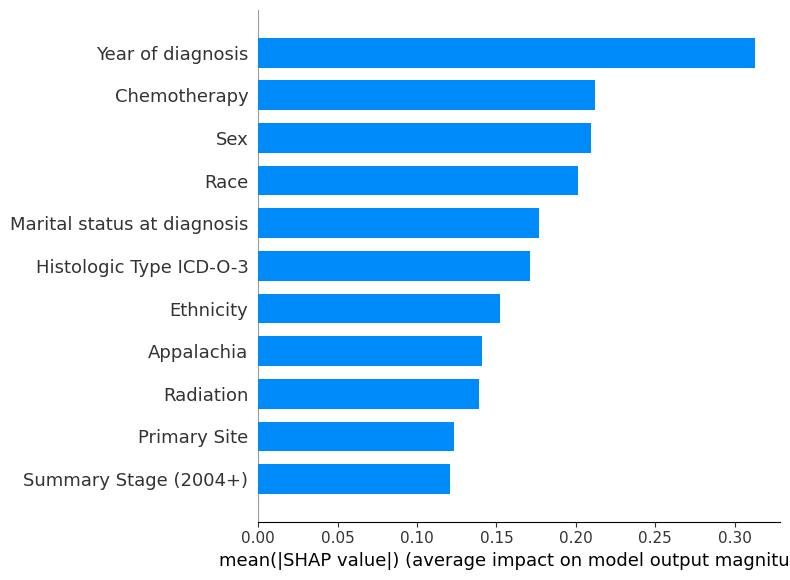

<Figure size 640x480 with 0 Axes>

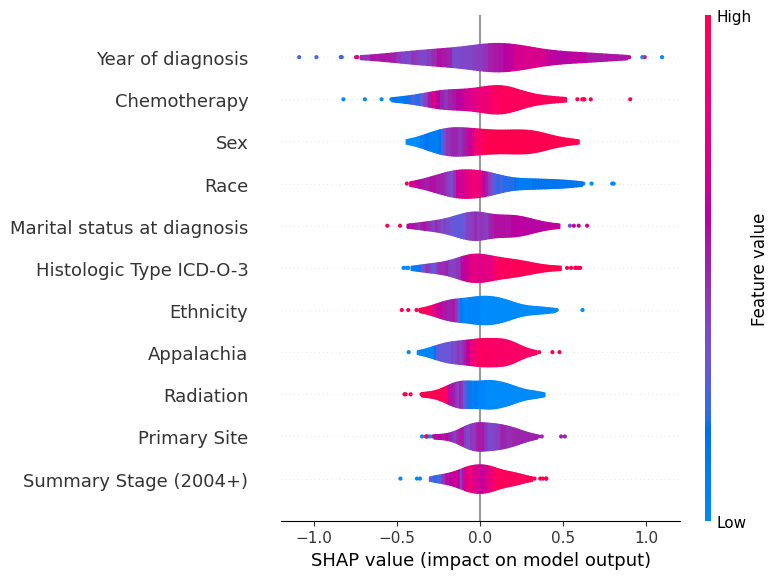

<Figure size 640x480 with 0 Axes>

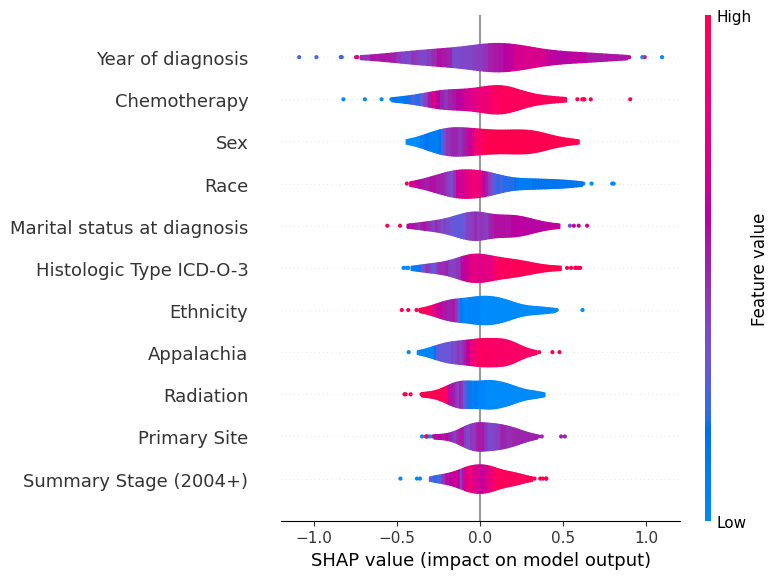

<Figure size 640x480 with 0 Axes>

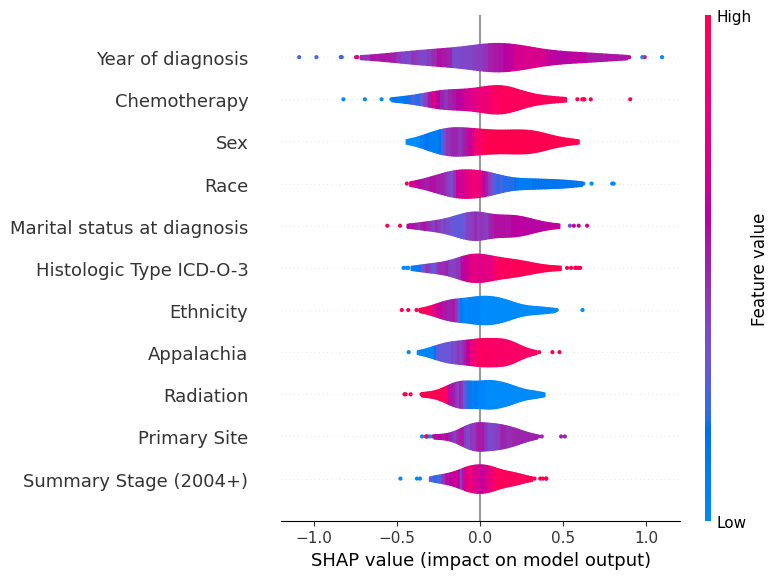

<Figure size 640x480 with 0 Axes>

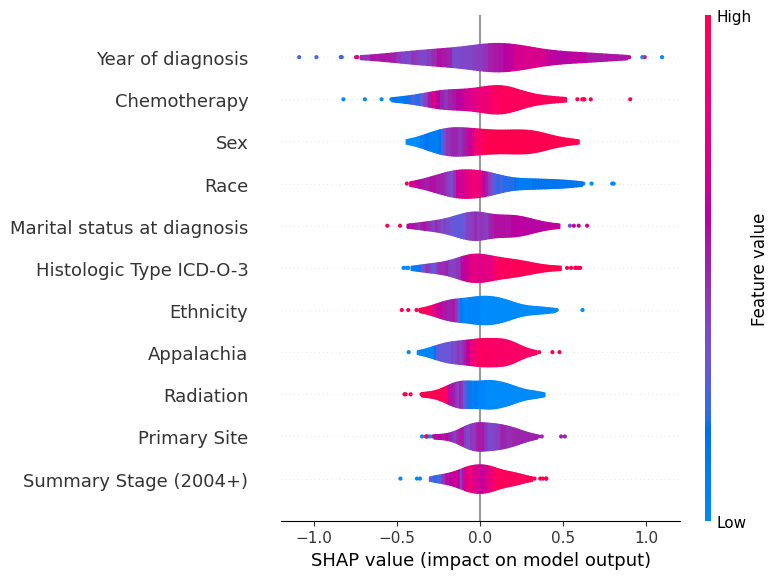

<Figure size 640x480 with 0 Axes>


Model Comparison Results:

AUC Scores:
Base Model: 0.4912
Modified Model: 0.4626

Disparate Impact Scores:

Race:
Base Model: 1.2399
Modified Model: 1.1557

Sex:
Base Model: 1.0130
Modified Model: 1.1524

Ethnicity:
Base Model: 1.0732
Modified Model: 1.1667

Appalachia:
Base Model: 1.0574
Modified Model: 1.0049

Top 5 Most Important Features:

Base Model:
Age with single ages and 100+    0.110414
Race                             0.108049
Marital status at diagnosis      0.104355
Year of diagnosis                0.101219
Ethnicity                        0.099621
dtype: float32

Modified Model:
Year of diagnosis          0.105151
Chemotherapy               0.097100
Appalachia                 0.091238
Sex                        0.091230
Histologic Type ICD-O-3    0.090898
dtype: float32


In [ ]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Create sample data matching your schema
def create_sample_data(n_samples=1000):
    np.random.seed(42)
    
    # Create data with the original column names (keys from selected_features)
    data = pd.DataFrame({
        'Age with single ages and 100+': np.random.randint(20, 100, n_samples),
        'Year of diagnosis': np.random.randint(2004, 2024, n_samples),
        'Sex': np.random.choice(['M', 'F'], n_samples),
        'Race': np.random.choice(['White', 'Black', 'Asian', 'Other'], n_samples),
        'Ethnicity': np.random.choice(['Hispanic', 'Non-Hispanic'], n_samples),
        'Primary Site': np.random.choice(['Site A', 'Site B', 'Site C'], n_samples),
        'Histologic Type ICD-O-3': np.random.choice(['Type 1', 'Type 2', 'Type 3'], n_samples),
        'Summary Stage (2004+)': np.random.choice(['Early', 'Advanced'], n_samples),
        'Marital status at diagnosis': np.random.choice(['Single', 'Married', 'Divorced', 'Widowed'], n_samples),
        'Appalachia': np.random.choice(['Yes', 'No'], n_samples),
        'Radiation': np.random.choice(['Yes', 'No'], n_samples),
        'Chemotherapy': np.random.choice(['Yes', 'No'], n_samples),
        'Survival': np.random.choice([0, 1], n_samples, p=[0.3, 0.7])  # Binary outcome
    })
    
    return data

def calculate_disparate_impact(predictions, protected_feature_values, threshold=0.5):
    """
    Calculate the disparate impact ratio for binary predictions
    """
    binary_predictions = (predictions >= threshold).astype(int)
    unique_values = np.unique(protected_feature_values)
    rates = {}
    
    for value in unique_values:
        mask = (protected_feature_values == value)
        positive_rate = binary_predictions[mask].mean()
        rates[value] = positive_rate
    
    max_rate = max(rates.values())
    min_rate = min(rates.values())
    
    return float('inf') if min_rate == 0 else max_rate / min_rate

def prepare_data(data, selected_features, include_treatment=False):
    """
    Prepare dataset with option to include treatment features
    """
    # Use the original column names (keys) instead of the mapped names (values)
    X = data[list(selected_features.keys())]
    
    if include_treatment:
        X['Radiation'] = data['Radiation']
        X['Chemotherapy'] = data['Chemotherapy']
    
    # Label encode categorical variables
    le_dict = {}
    for column in X.select_dtypes(include=['object']):
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))
        le_dict[column] = le
    
    return X, le_dict

def train_and_analyze_model(X, y, protected_features, model_name="Base"):
    """
    Train XGBoost model and analyze feature importance and disparate impact
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train XGBoost model
    model = XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Calculate predictions and performance
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Calculate disparate impact for each protected feature
    di_scores = {}
    for feature in protected_features:
        di_score = calculate_disparate_impact(y_pred_proba, X_test[feature])
        di_scores[feature] = di_score
    
    # SHAP Analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # SHAP Summary Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type="bar", 
                      title=f"SHAP Feature Importance - {model_name}",
                      show=True)
    plt.tight_layout()
    plt.savefig(f'shap_summary_{model_name}.png')
    plt.show()
    
    # Bias SHAP Plot for each protected feature
    for feature in protected_features:
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test, 
                          plot_type="violin", 
                          color_bar=True, 
                          show=True,
                          class_names=["Negative", "Positive"],
                          title=f"SHAP Bias Analysis - {feature}")
        plt.tight_layout()
        plt.savefig(f'shap_bias_{model_name}_{feature}.png')
        plt.show()
    
    return {
        'model': model,
        'auc_score': auc_score,
        'disparate_impact': di_scores,
        'feature_importance': pd.Series(model.feature_importances_, index=X.columns),
        'shap_values': shap_values
    }

# Your feature definitions (original column names)
selected_features = {
    'Age with single ages and 100+': 'Age',
    'Year of diagnosis': 'DiagnosisYear',
    'Sex': 'Sex',
    'Race': 'Race',
    'Ethnicity': 'Ethnicity',
    'Primary Site': 'PrimarySite',
    'Histologic Type ICD-O-3': 'TumorGrade',
    'Summary Stage (2004+)': 'SummaryStage',
    'Marital status at diagnosis': 'MaritalStatus',
    'Appalachia': 'Appalachia'
}

# Create sample data
data = create_sample_data(n_samples=1000)

# Create two feature sets
base_features = selected_features.copy()
modified_features = selected_features.copy()
del modified_features['Age with single ages and 100+']  # Remove Age

# Protected features for bias analysis
protected_features = ['Race', 'Sex', 'Ethnicity', 'Appalachia']

# Get target variable
y = data['Survival']

# Train and analyze base model
X_base, le_dict_base = prepare_data(data, base_features)
base_results = train_and_analyze_model(X_base, y, protected_features, "Base_Model")

# Train and analyze modified model with treatments and without age
X_modified, le_dict_modified = prepare_data(data, modified_features, include_treatment=True)
modified_results = train_and_analyze_model(X_modified, y, protected_features, "Modified_Model")

# Print comparison results
print("\nModel Comparison Results:")
print("========================")

print("\nAUC Scores:")
print(f"Base Model: {base_results['auc_score']:.4f}")
print(f"Modified Model: {modified_results['auc_score']:.4f}")

print("\nDisparate Impact Scores:")
for feature in protected_features:
    print(f"\n{feature}:")
    print(f"Base Model: {base_results['disparate_impact'][feature]:.4f}")
    print(f"Modified Model: {modified_results['disparate_impact'][feature]:.4f}")

print("\nTop 5 Most Important Features:")
print("\nBase Model:")
print(base_results['feature_importance'].sort_values(ascending=False).head())
print("\nModified Model:")
print(modified_results['feature_importance'].sort_values(ascending=False).head())